# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Первый взгляд на данные и импорт всего-всего

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [2]:
import os

pth1 = '/datasets/autos.csv'
pth11 = 'autos.csv'

if os.path.exists(pth1):
    autos = pd.read_csv(pth1)
elif os.path.exists(pth11):
    autos = pd.read_csv(pth11)
else:
    print('Something is wrong')

pd.set_option('display.max_columns', None)

### 1. Сначала просто посмотрим на данные

In [3]:
autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Как мы можем видеть, данные совпадают с заявленными.

### 2. Теперь проверим типы данных в столбцах

In [4]:
autos.head(1)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57


In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Уже видно очень много косяков в данных. Например, огромное количество пропусков. В дате регистрации, например, есть тысячный год, нулевой месяц и так далее, в общем очень весело будет. 

## Подготовка данных

### 1. Обработаем пропущенные значения

In [7]:
missing_values = autos.isnull().sum()
missing_data_df = pd.DataFrame({'Missing Values': missing_values})
missing_data_df[missing_data_df['Missing Values'] > 0]

,Missing Values
VehicleType,37490
Gearbox,19833
Model,19705
FuelType,32895
Repaired,71154


Как можно заметить, самое большое количество пропусков в столбце о статусе починки авто. Вероятно, если не указано, значит авто не чинилось. Насчет остального, можем заполнить самым частым значением

In [8]:
autos['Repaired'].fillna('no', inplace=True)

In [9]:
autos["VehicleType"] = autos["VehicleType"].fillna(autos["VehicleType"].mode().values[0])
autos["Gearbox"] = autos["Gearbox"].fillna(autos["Gearbox"].mode().values[0])
autos["Model"] = autos["Model"].fillna(autos["Model"].mode().values[0])
autos["FuelType"] = autos["FuelType"].fillna(autos["FuelType"].mode().values[0])

In [10]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### 2. Теперь обработаем полные дубликаты

In [11]:
autos.duplicated().sum()

5

In [12]:
autos.drop_duplicates(inplace=True)

In [13]:
autos.duplicated().sum()

0

In [14]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354364 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354364 non-null  object
 1   Price              354364 non-null  int64 
 2   VehicleType        354364 non-null  object
 3   RegistrationYear   354364 non-null  int64 
 4   Gearbox            354364 non-null  object
 5   Power              354364 non-null  int64 
 6   Model              354364 non-null  object
 7   Kilometer          354364 non-null  int64 
 8   RegistrationMonth  354364 non-null  int64 
 9   FuelType           354364 non-null  object
 10  Brand              354364 non-null  object
 11  Repaired           354364 non-null  object
 12  DateCreated        354364 non-null  object
 13  NumberOfPictures   354364 non-null  int64 
 14  PostalCode         354364 non-null  int64 
 15  LastSeen           354364 non-null  object
dtypes: int64(7), object(

Дубликаты удалены, количество данных изменилось, значит все гуд

### 3. Теперь обработаем аномалии

Первое что бросается в глаза это столбец с мощностью авто

In [15]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000,354364.0,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641,0.0,50508.461698
std,4514.159690,90.228593,189.851590,37905.136957,3.726433,0.0,25783.124276
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49409.500000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


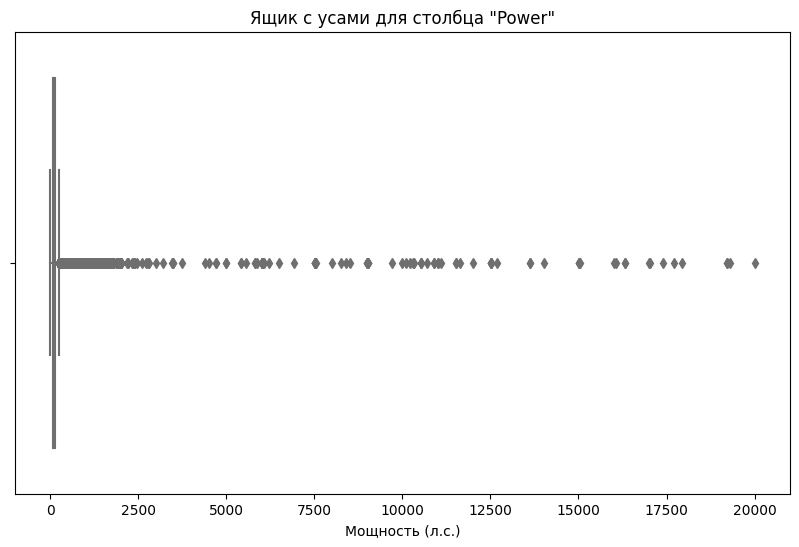

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=autos['Power'], color='skyblue')
plt.title('Ящик с усами для столбца "Power"')
plt.xlabel('Мощность (л.с.)')
plt.show()

Да, авто с огромной мощностью действительно существуют, но кажется такие выбросы все же могут повлиять на модель. Ограничим мощность авто значением 3500

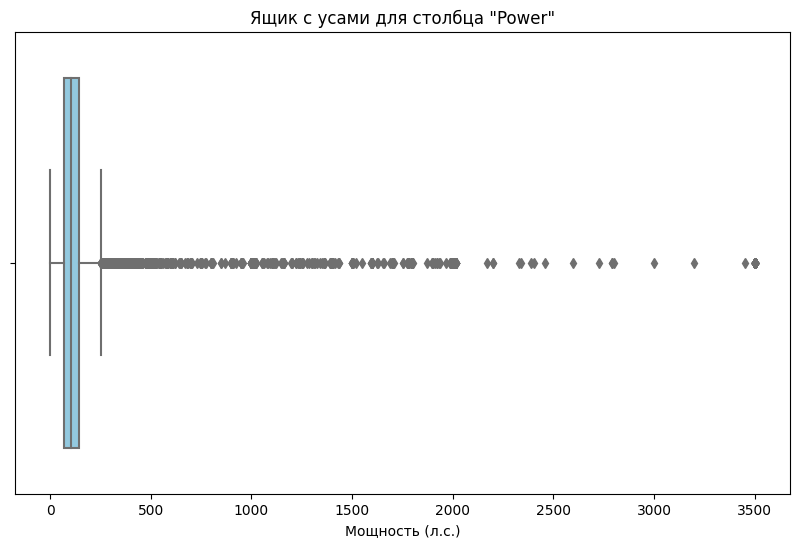

In [17]:
autos.loc[autos['Power'] > 3500, 'Power'] = 3500
plt.figure(figsize=(10, 6))
sns.boxplot(x=autos['Power'], color='skyblue')
plt.title('Ящик с усами для столбца "Power"')
plt.xlabel('Мощность (л.с.)')
plt.show()

Аномальные значения года регистрации приведем к общей границе, изменим нулевой месяц в дате на первый. С ценой и мощностью тяжелее, там придется использовать квантили. Напишем для этого функцию

In [18]:
def remover(df,column):
    del_index = []
    q25 = np.array(df[column].quantile(0.25))
    q75 = np.array(df[column].quantile(0.75))
    first = q25 - 1.5 * (q75 - q25)
    second = q75 + 1.5 * (q75 - q25)
    for index_value, value in zip(df[column].index,df[column]):
        if second <= value or value <= first:
            del_index.append(index_value)
    return del_index

In [19]:
autos['RegistrationYear'] = autos['RegistrationYear'].apply(lambda x: min(2020, max(1930, x)))

In [20]:
autos.loc[autos['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

In [21]:
count = 0
A = ["Price","Power"]
for column in A:
    index_del = remover(autos,column)
    count += len(index_del)
    autos = autos.drop(index_del,axis = 0)

In [22]:
autos = autos[(autos["Price"] > 100) & (autos["Power"] > 10)]

In [23]:
autos[A].describe()

,Price,Power
count,281850.000000,281850.000000
mean,3998.729959,113.401476
std,3460.092828,44.188332
min,101.000000,11.000000
25%,1250.000000,75.000000
50%,2800.000000,107.000000
75%,5950.000000,140.000000
max,14400.000000,252.000000


In [24]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281850 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        281850 non-null  object
 1   Price              281850 non-null  int64 
 2   VehicleType        281850 non-null  object
 3   RegistrationYear   281850 non-null  int64 
 4   Gearbox            281850 non-null  object
 5   Power              281850 non-null  int64 
 6   Model              281850 non-null  object
 7   Kilometer          281850 non-null  int64 
 8   RegistrationMonth  281850 non-null  int64 
 9   FuelType           281850 non-null  object
 10  Brand              281850 non-null  object
 11  Repaired           281850 non-null  object
 12  DateCreated        281850 non-null  object
 13  NumberOfPictures   281850 non-null  int64 
 14  PostalCode         281850 non-null  int64 
 15  LastSeen           281850 non-null  object
dtypes: int64(7), object(

Данных стало меньше примерно на 20.000, двигаемся дальше

### 4. Удалим неинформативные столбцы

К неинформативным можно отнести все даты, количество фото и почтовый индекс

In [25]:
autos = autos.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)

In [26]:
autos.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


Теперь снова проверим данные на дубликаты

In [27]:
autos.duplicated().sum()

26535

Ого, на удивление их снова стало много, уберем их

In [28]:
autos.drop_duplicates(inplace=True)

In [29]:
autos.duplicated().sum()

0

Убрали, готово

### 5. Подготовим выборки для обучения. Учитывая что мы будем использовать кэт, придется поделить данные немного хитрее

In [30]:
# Создаем копии датафрейма autos
autos_ohe = autos.copy()
autos_ano = autos.copy()

# Инициализируем OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Категориальные столбцы для преобразования
categorical_columns = ['Repaired', 'VehicleType', 'FuelType', 'Brand', 'Model', 'Gearbox']

# Применяем OneHotEncoder к autos_ohe
autos_ohe_encoded = pd.DataFrame(encoder.fit_transform(autos_ohe[categorical_columns]))
autos_ohe_encoded.columns = encoder.get_feature_names_out(categorical_columns)

# Удаляем старые категориальные столбцы и добавляем новые
autos_ohe.drop(categorical_columns, axis=1, inplace=True)
autos_ohe = pd.concat([autos_ohe, autos_ohe_encoded], axis=1)

# Преобразуем выбранные категориальные признаки в категориальные переменные для autos_ano
autos_ano[categorical_columns] = autos_ano[categorical_columns].astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    autos.drop("Price", axis=1),
    autos["Price"],
    test_size=0.25,
    random_state=42
)

# Разделяем данные на тренировочный и тестовый наборы для autos_ohe
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    autos_ohe.drop("Price", axis=1),
    autos_ohe["Price"],
    test_size=0.25,
    random_state=42
)

# Разделяем данные на тренировочный и тестовый наборы для autos_ano
X_train_ano, X_test_ano, y_train_ano, y_test_ano = train_test_split(
    autos_ano.drop("Price", axis=1),
    autos_ano["Price"],
    test_size=0.25,
    random_state=42
)

/Users/daniilzukov/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Итого получаем три разных набора с разными видами обработки

In [31]:
X_train_ohe.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,Repaired_no,Repaired_yes,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_alfa_romeo,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Model_100,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,Gearbox_auto,Gearbox_manual
60588,1995.0,125.0,150000.0,1

## Обучение моделей

### 1. Обучение и оценка модели линейной регрессии

Сначала будет случайный лес

In [32]:
# Создаем копию датафрейма
autos_encoded = autos.copy()

# Инициализируем OrdinalEncoder
encoder = OrdinalEncoder()

# Категориальные столбцы для преобразования
categorical_columns = ['Repaired', 'VehicleType', 'FuelType', 'Brand', 'Model', 'Gearbox']

# Применяем OrdinalEncoder к категориальным столбцам
autos_encoded[categorical_columns] = encoder.fit_transform(autos_encoded[categorical_columns])

# Разделяем данные на тренировочный и тестовый наборы
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    autos_encoded.drop("Price", axis=1),
    autos_encoded["Price"],
    test_size=0.25,
    random_state=42
)

In [33]:
%%time
RF = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1)
RF.fit(X_train_enc, y_train_enc)

CPU times: user 23.7 s, sys: 287 ms, total: 24 s
Wall time: 2.89 s


RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)

Далее кэт

In [34]:
%%time
catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = {'depth': [6, 10], 'learning_rate': np.arange(0.1, 1, 0.3)}
catboost_grid = catboost.grid_search(parameters_cat, 
                                     Pool(X_train_enc, y_train_enc),
                                     cv=3,
                                     verbose=True,
                                     plot=False)

0:	learn: 4838.3201059	test: 4864.6975772	best: 4864.6975772 (0)	total: 68.9ms	remaining: 1m 8s
1:	learn: 4459.5307086	test: 4485.7016515	best: 4485.7016515 (1)	total: 76.1ms	remaining: 38s
2:	learn: 4124.4496371	test: 4150.4200820	best: 4150.4200820 (2)	total: 83.3ms	remaining: 27.7s
3:	learn: 3813.0919302	test: 3839.3631156	best: 3839.3631156 (3)	total: 91.2ms	remaining: 22.7s
4:	learn: 3542.0217549	test: 3567.8380132	best: 3567.8380132 (4)	total: 99.9ms	remaining: 19.9s
5:	learn: 3302.3843495	test: 3328.1483354	best: 3328.1483354 (5)	total: 109ms	remaining: 18s
6:	learn: 3097.1654451	test: 3122.8542916	best: 3122.8542916 (6)	total: 115ms	remaining: 16.4s
7:	learn: 2912.1766596	test: 2937.5318509	best: 2937.5318509 (7)	total: 123ms	remaining: 15.2s
8:	learn: 2751.0598556	test: 2775.3626530	best: 2775.3626530 (8)	total: 131ms	remaining: 14.4s
9:	learn: 2607.7706311	test: 2631.2824496	best: 2631.2824496 (9)	total: 139ms	remaining: 13.8s
10:	learn: 2484.2440096	test: 2506.5009101	best: 

Нашли лучший параметр, его и применим

In [35]:
catboost_grid["params"]

{'depth': 10, 'learning_rate': 0.1}

In [36]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"],
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',
                              verbose=100)
final_cat.fit(Pool(X_train_enc, y_train_enc))

0:	learn: 3225.2687071	total: 11.2ms	remaining: 11.2s
100:	learn: 1355.3788901	total: 957ms	remaining: 8.52s
200:	learn: 1287.0964159	total: 1.92s	remaining: 7.62s
300:	learn: 1248.1271142	total: 2.88s	remaining: 6.69s
400:	learn: 1216.3691270	total: 3.85s	remaining: 5.75s
500:	learn: 1190.9281785	total: 4.81s	remaining: 4.79s
600:	learn: 1170.7222231	total: 5.78s	remaining: 3.84s
700:	learn: 1153.3991792	total: 6.75s	remaining: 2.88s
800:	learn: 1136.6909629	total: 7.7s	remaining: 1.91s
900:	learn: 1123.2074598	total: 8.66s	remaining: 952ms
999:	learn: 1111.0010586	total: 9.62s	remaining: 0us
CPU times: user 40.1 s, sys: 7.04 s, total: 47.2 s
Wall time: 9.77 s


Теперь LightGBM

In [37]:
%%time
lgb_train = lgb.Dataset(X_train_enc, y_train_enc)
lgb_test = lgb.Dataset(X_test_enc, y_test_enc, reference=lgb_train)
params = {
    'metric': 'rmse',
    'max_depth': 10,
    'num_leaves': 32,
    'random_state': 42,
    'learning_rate': 0.1,
    'force_col_wise': True
}
light = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train, lgb_test])

[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 191486, number of used features: 10
[LightGBM] [Info] Start training from score 3984.502058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 11.5 s, sys: 8.69 s, total: 20.2 s
Wall time: 8.07 s


Теперь сравним модели

In [38]:
X_train_enc, X_val_enc, y_train_enc, y_val_enc = train_test_split(
    X_train_enc,
    y_train_enc,
    test_size=0.2,
    random_state=42
)

In [39]:
%%time
print("RandomForest:", mean_squared_error(y_val_enc, RF.predict(X_val_enc), squared=False))

RandomForest: 661.6388506406254
CPU times: user 978 ms, sys: 64.2 ms, total: 1.04 s
Wall time: 127 ms


In [40]:
%%time
print("CatBoost:", mean_squared_error(y_val_enc, catboost.predict(X_val_enc), squared=False))

CatBoost: 1113.5036950292915
CPU times: user 77.2 ms, sys: 3.77 ms, total: 80.9 ms
Wall time: 14.5 ms


In [41]:
%%time
print("LightGBM:", mean_squared_error(y_val_enc, light.predict(X_val_enc), squared=False))

LightGBM: 1160.6862356748654
CPU times: user 1.58 s, sys: 4.21 ms, total: 1.58 s
Wall time: 187 ms


Теперь проведем тестирование лучшей модели для контроля переобучения

In [42]:
%%time
lightgbm_test_predictions = light.predict(X_test_enc)
lightgbm_test_mse = mean_squared_error(y_test_enc, lightgbm_test_predictions, squared=False)
print("LightGBM RMSE на тестовой выборке:", lightgbm_test_mse)

LightGBM RMSE на тестовой выборке: 1306.6094919325456
CPU times: user 2.66 s, sys: 4.46 ms, total: 2.66 s
Wall time: 283 ms


Итак, тестирование проведено. Мы видим, что качество метрики в целом на том же уровне, обучается все так же очень быстро и быстро работает, в общем сочетает в себе самое лучшее. 

## Анализ моделей

Таким образом, мы обучили три разные модели и сейчас сравним их по предоставленным нам актуальным параметрам для оценки моделей. 
Итак, по качеству модели выиграл RandomForest
по времени обучения выиграл LightGBM
По времени предсказания выиграл CatBoost, однако лайт все так же близок к победе

Итого, основываясь на результатах исследования, в приоритете мы рассматриваем LightGBM так как он в среднем стабилен и качественен

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей